In [2]:
import sys
sys.path.append('/home/alysha/Downloads')


In [3]:
"""
Created on Mon Dec  4 10:55:54 2017

@author: alyshadesouza
"""

 
import numpy as np
import matplotlib
from neo.io import AxonIO
#import seaborn as sns
import matplotlib.pyplot as plt
from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
import thllib #import util
import figurefirst as fifi
from scipy import signal




/home/alysha/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
%matplotlib inline



In [5]:
fly = flb.NetFly(2001,rootpath='/home/alysha/media/imager/FlyDataD/FlyDB/')
fly.open_signals()

In [6]:
abf_sp = fly.abf_times[1] #abf spike period
ca_frame_in_abf = np.int(0.02/abf_sp) #abf period in abf idxs

#get the idx's where the ca data is aquired
ep_idx = np.where(np.array(fly.abf_led_pulse)>1.0)[0]
start = ep_idx[0]+np.int(1.5*ca_frame_in_abf) #the calcium data starts at the end of one trigger period 
stop = ep_idx[-1]+np.int(1.5*ca_frame_in_abf)

#make a time array for the recording epoch
ep_times = np.array(fly.abf_times[start:stop])
ep_times -= ep_times[0]

#load this into memory since I will use it quite a bit
spike_sig = np.array(fly.abf_electrode[start:stop])
##make sure to sore this spike signal again -- messy input from B1, B2 and iii3
####i1_ca = fly.ca_camera_left_model_fits['i1']
## another way of extracting b1 activity
#F_ = np.mean(fly.ca_camera_left[:,24:34,75:100],axis = (1,2))
#F = np.percentile(F_,0.01)
#DF_F = (F_-F)/F
#b1_ca = DF_F

/home/alysha/.local/lib/python2.7/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


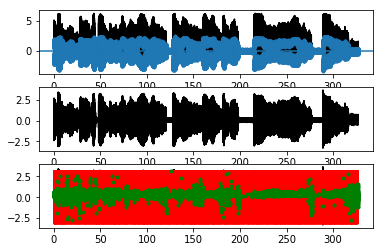

In [9]:
# import the data
#flydir = '/Volumes/hm_data/MN optogenetic activation/b1/1218 fly 3/'


#localfile = flydir + '2017_12_15_0001.abf'

#localfile = '/home/alysha/Documents/12_15_2017_abf_files/2017_12_15_0001.abf'
#localfile= '2017_12_15_0022.abf'
localfilename = '2018_03_26_0008.abf'
r =AxonIO(localfilename)
 
bl = r.read_block(lazy=False, cascade=True)
 
hutch = np.asarray(bl.segments[0].analogsignals[5])
 
fs_axon = 1.0/20000.0
 
times=np.linspace(0,len(hutch)/(1/fs_axon),len(hutch))
 
# detrend hütchens signal
hutch_det = hutch - np.mean(hutch)
 
ax1 = plt.subplot(311)
 
ax1.plot(times,hutch_det,'k')
 
#identify all relative minima
from scipy.signal import argrelmin
inds = argrelmin(hutch_det, order = 5)
ax1.plot(times[inds], hutch_det[inds], '.')
ax1.axhline(-0.08)
inds = np.array(inds)
inds = np.transpose(inds)
 
 
## identify the ventral flip of each wingbeat by applying a threshold
thresh = -.01 #adjust as needed
flipInds = []
flipInds = np.argwhere(hutch_det[inds]>thresh)
flipInds = inds[flipInds]
flipInds = flipInds[:,0]
 
#% now find the phase of the ventral flip 
 
#filter hütchen signal to make it more sinusoidal
 
from scipy import signal
from scipy.signal import butter, lfilter, freqz
 
def butter_lowpass(highcut, fs, order=4):
    nyq = 0.5 * fs
    #low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [high], btype='low', analog=False)
    return b, a
 
 
# Filter requirements.
order = 4
fs = 20000.0       # sample rate, Hz
lowcut = 100
highcut = 300.0  # desired cutoff frequency of the filter, Hz
 
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(highcut, fs, order)
 
 
hutch_filt = signal.filtfilt(b, a, hutch_det)
 
ax2 = plt.subplot(312, sharex=ax1)
 
ax2.plot(times,hutch_filt,'k')
 
# perform a Hilbert transformation on the filtered signal to calculate instantaneous phase, amplitude, etc.
from scipy.signal import hilbert
 
hutch_analytic = hilbert(hutch_filt)
inst_phase = np.angle(hutch_analytic)
 
 
ax3 = plt.subplot(313, sharex=ax1)
 
# plot the identified ventral flip on the phase data
ax3.plot(times,hutch_analytic,'k')
ax3.plot(times,inst_phase,'r')
ax3.plot(times[flipInds],inst_phase[flipInds],'g.')

#%matplotlib inline 
#%pylab inline
#%matplotlib inline


import numpy as np
import scipy.signal as scs
import matplotlib.pyplot as plt
#from constrained_foopsi import *
#%matplotlib inline

In [10]:
import sys


In [11]:
!pwd
#%matplotlib inline  

/home/alysha/media/imager/FlyDataD/FlyDB/Fly2001


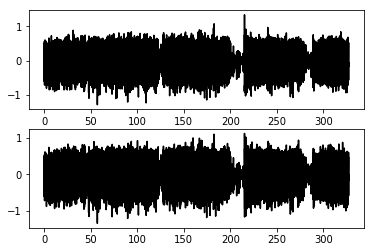

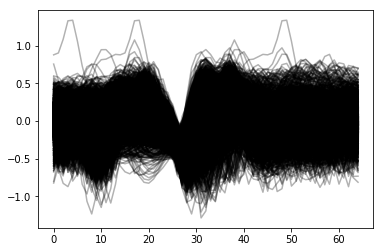

In [12]:
#%% detect muscle spikes and sort them
 
musc = np.asarray(bl.segments[0].analogsignals[0])
 
plt.figure(2)
ax1 = plt.subplot(211)
ax1.plot(times,musc,'k')
 
#apply median filter and detrend muscle signal
 
musc_det = musc-signal.medfilt(musc,35)
 
ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(times,musc_det,'k')
 
# threshold the detrended signal (convert the spikes into binary)
# calculate the change in, identify the spike starts/stops 
#thresh = 4
thresh = 0.25 #0.6
deltas = np.diff(np.array(-1*musc_det>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]
  
#find the peak changes in the thresholded signal, and find the associated waveform   
intervals = np.hstack((starts,stops))
spiketimes = [np.argmax(musc[sta:stp])+sta for sta,stp in intervals][2:-2]
waveforms = [musc[pk-25:pk+40] for pk in spiketimes]
 
#plot the collected waveforms
plt.figure(3)
for i in range(len(waveforms)):
    plt.plot(waveforms[i], 'k', alpha = 0.3)
 
wv_mtrx = np.vstack([np.array(wv) for wv in waveforms])



KeyboardInterrupt: 

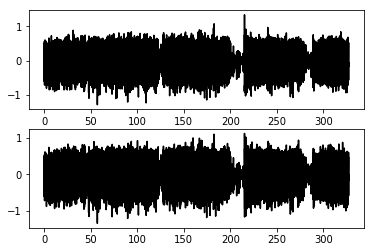

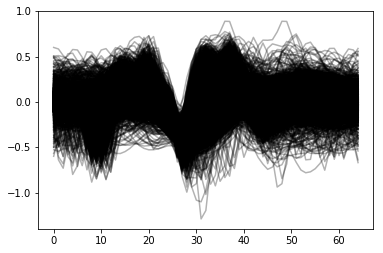

In [13]:
####duplicate

#%% detect muscle spikes and sort them
 
musc = np.asarray(bl.segments[0].analogsignals[0])
 
plt.figure(2)
ax1 = plt.subplot(211)
ax1.plot(times,musc,'k')
 
#apply median filter and detrend muscle signal
 
musc_det = musc-signal.medfilt(musc,35)
 
ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(times,musc_det,'k')
 
# threshold the detrended signal (convert the spikes into binary)
# calculate the change in, identify the spike starts/stops 
#thresh = 4
thresh = 0.25 #0.6
deltas = np.diff(np.array(-1*musc_det>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]
  
#find the peak changes in the thresholded signal, and find the associated waveform   
intervals = np.hstack((starts,stops))
spiketimes = [np.argmax(musc[sta:stp])+sta for sta,stp in intervals][2:-2]
waveforms = [musc[pk-25:pk+40] for pk in spiketimes]
 
#plot the collected waveforms
plt.figure(3)
for i in range(len(waveforms)):
    plt.plot(waveforms[i], 'k', alpha = 0.3)
 
wv_mtrx = np.vstack([np.array(wv) for wv in waveforms])





In [ ]:
#%matplotlib inline


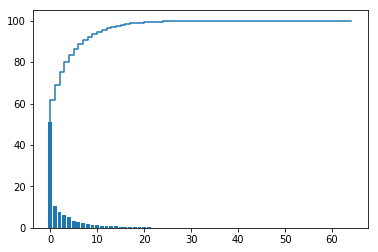

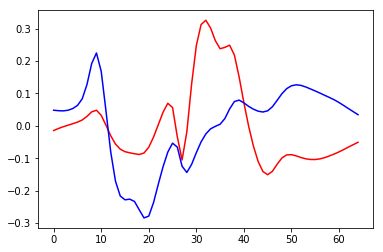

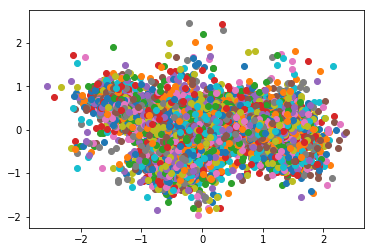

In [14]:
#%% extract the features of the waveforms to cluster the data
 
cov_wav = np.cov(wv_mtrx.T)
eig_vals, eig_vecs = np.linalg.eig(cov_wav)
#for ev in eig_vecs:
    #np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
 
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
 
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)
 
# Visually confirm that the list is correctly sorted by decreasing eigenvalues
 
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
 
plt.figure(4)
plt.bar(range(65), var_exp)
plt.step(range(65), cum_var_exp)
 
#contruct the projection matrix
matrix_w = np.hstack((eig_pairs[0][1].reshape(65,1),
                      eig_pairs[1][1].reshape(65,1)))
 
plt.figure(5)
plt.plot(matrix_w[:,0],'r')
plt.plot(matrix_w[:,1],'b')
 
plt.figure(6)
proj = []
proj1 = []
proj2 =[]
for i in range(len(wv_mtrx)):
    musc_proj = np.dot(wv_mtrx[i], matrix_w)
    proj.append(musc_proj[0])
    proj1.append(musc_proj[1])
    proj2.append(musc_proj)
    plt.scatter(musc_proj[0], musc_proj[1])
 
     
X = np.array(list(zip(proj, proj1)))
 
    

[[ 1.09640952  0.09348299]
 [-1.3158774   0.56417875]
 [-0.39552523 -0.83166985]
 [-0.07784786  0.1464891 ]]


' \ntest3 = np.argwhere(labels=0)\n \nfor i in range(len(test3)):\n    plt.plot(wv_mtrx[test3[i]])\n'

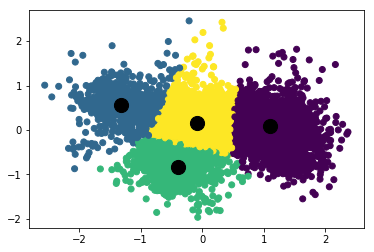

In [15]:
#%%
from sklearn.cluster import KMeans
 
# Number of clusters
#kmeans = KMeans(n_clusters=2)
#n_clusters=1
n_clusters=4
kmeans = KMeans(n_clusters=4)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_
 
#print(C) 
print(centroids)
 
plt.figure(7)
plt.scatter(X[:, 0], X[:, 1], c=labels)
 
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200);
 
""" 
test3 = np.argwhere(labels=0)
 
for i in range(len(test3)):
    plt.plot(wv_mtrx[test3[i]])
"""
    

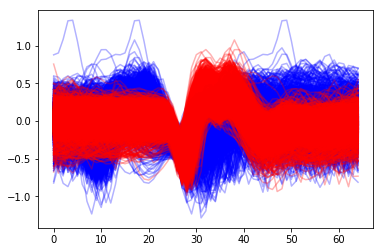

In [16]:
#%%


###### categorize and plot the labels 

labeled_spikes= zip(spiketimes,labels)


def cutoff(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] > threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

Type_a_spikes = cutoff(0.5, labeled_spikes)

def cutoff_2(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] < threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

Type_b_spikes = cutoff_2(0.5, labeled_spikes)



#print(zip_hutch)
#
x_val = [x[0] for x in Type_a_spikes]
y_val = [x[1] for x in Type_a_spikes]

x_val_b = [x[0] for x in Type_b_spikes]
y_val_b = [x[1] for x in Type_b_spikes]



labeled_waveforms_type_a = [musc[pk-25:pk+40] for pk in x_val]

labeled_waveforms_type_b = [musc[pk-25:pk+40] for pk in x_val_b]
 
#plot the collected waveforms
plt.figure(3)
for i in range(len(labeled_waveforms_type_a)):
    plt.plot(labeled_waveforms_type_a[i], 'b', alpha = 0.3)

plt.figure(3)
for i in range(len(labeled_waveforms_type_b)):
    plt.plot(labeled_waveforms_type_b[i], 'r', alpha = 0.3)
    
#go back and plot the labeled peaks
#find old code on old computer for this
#improve documentation for this



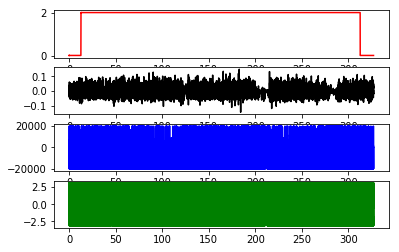

In [19]:
#%%

###Use Hilbert function againt o calculate the instantaneous freq. of B2

plt.figure(12)

# Filter requirements.
order = 10  #4
fs = 20000.0       # sample rate, Hz
lowcut = 100
highcut = 200.0  # desired cutoff frequency of the filter, Hz



def butter_lowpass_1(highcut, fs, order=10):
    nyq = 0.5 * fs
    #low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [high], btype='low', analog=False)
    return b, a
 
 

 
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass_1(highcut, fs, order)
 
 
muscb2_filt = signal.filtfilt(b, a, musc_det)

ax1 = plt.subplot(411)
ax1.plot(times, crimson, 'r')
 
ax2 = plt.subplot(412, sharex=ax1)
 
ax2.plot(times,muscb2_filt,'k')
 
# perform a Hilbert transformation on the filtered signal to calculate instantaneous phase, amplitude, etc.
from scipy.signal import hilbert
 
musc_analytic = hilbert(muscb2_filt)
inst_phase = np.angle(musc_analytic)

#instantaneous_phase = np.unwrap(np.angle(musc_analytic))
instantaneous_frequency = (np.diff(inst_phase) /(2.0*np.pi) * fs)
 
ax3 = plt.subplot(413, sharex=ax1)
 
# plot the identified ventral flip on the phase data
ax3.plot(times,musc_analytic,'k')
#ax3.plot(times,inst_phase,'r')

times_freq = np.delete(times, 3134719)

ax3.plot(times_freq, instantaneous_frequency, 'b')
#ax3.plot(times[flipInds],inst_phase[flipInds],'g.')

ax4 = plt.subplot(414, sharex=ax1)
ax4.plot(times, inst_phase, 'g')



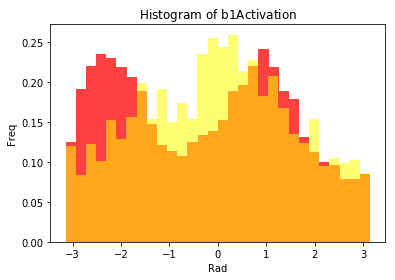

In [18]:
#With crimson light!

crimson = np.asarray(bl.segments[0].analogsignals[7])


plt.figure(13)
ax1 = plt.subplot(111)

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

#split via crimson

#ax1.plot(times,crimson,'r')
#plt.fill_between(times[inds],crimson[inds])

#crimson_labeled_spikes_0= zip(inst_phase[x_val], crimson[x_val], musc[x_val])
crimson_labeled_spikes_2= zip(inst_phase[x_val_b], crimson[x_val_b], musc[x_val_b])


def cutoff_crimson(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList2 = filter(lambda x: x[1] > threshold, sortedData)
    finalList =filter(lambda x: x[0] < 45, finalList2)
    return finalList if len(finalList) > 2 else 'No values found'

#Spikes_1_crimson = cutoff_crimson(0.2, crimson_labeled_spikes_0)
Spikes_2_crimson = cutoff_crimson(.2, crimson_labeled_spikes_2)

def cutoff_no_crimson(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList2 = filter(lambda x: x[1] < threshold, sortedData)
    finalList =filter(lambda x: x[0] < 45, finalList2)
    return finalList if len(finalList) > 2 else 'No values found'

#Spikes_1_no_crimson = cutoff_no_crimson(0.2, crimson_labeled_spikes_0)
Spikes_2_no_crimson = cutoff_no_crimson(0.2, crimson_labeled_spikes_2)



#print(zip_hutch)


#x_val_crimson_1 = [x[0] for x in Spikes_1_crimson]
x_val_crimson_2 = [x[0] for x in Spikes_2_crimson] #COMPARING PHASE


#x_val_no_crim_1 = [x[0] for x in Spikes_1_no_crimson]

x_val_no_crim_2 = [x[0] for x in Spikes_2_no_crimson]



#labeled_waveforms_type_a = [musc[pk-25:pk+40] for pk in x_val]

#labeled_waveforms_type_b = [musc[pk-25:pk+40] for pk in x_val_b]


#hist_crimson_spikes = x_val_crimson_1 
#hist_no_crimson_spikes = x_val_no_crim_1 

hist_crimson_spikes = x_val_crimson_2
hist_no_crimson_spikes = x_val_no_crim_2

matplotlib.pyplot.hist(hist_crimson_spikes, bins=30, normed=1, facecolor='red', alpha=0.75)
matplotlib.pyplot.hist(hist_no_crimson_spikes, bins=30, normed=1, facecolor='yellow', alpha=0.55)

####for B2
#matplotlib.pyplot.hist(hist_crimson_spikes, bins=60, normed=1, facecolor='red', alpha=0.75)
#matplotlib.pyplot.hist(hist_no_crimson_spikes, bins=60, normed=1, facecolor='yellow', alpha=0.55)



#mu, sigma = 100, 15
bins = 100
#x = mu + sigma*np.random.randn(10000)

# the histogram of the data
#n, bins, patches = plt.hist(musc_det[x_val_0], 50, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('Rad')
plt.ylabel('Freq')
plt.title(r'$\mathrm{Histogram\ of\ b1  Activation}$')
#plt.title(r'$\mathrm{Histogram\ of\ b2  Activation}$')
#plt.axis([40, 160, 0, 0.03])
plt.grid(False)

plt.show()

# sanity check: just plot instantaneous phase over the whole experiment
#plt.figure(14)
#plt.plot(inst_phase[x_val_b], 'k')


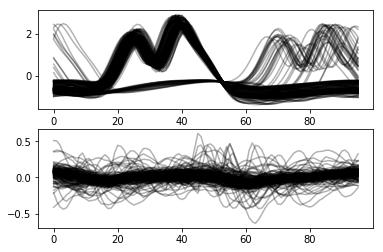

In [23]:
#%% gather a subset of the hütchens before and during a stimulus period to display them overlaid

hutch_seg = hutch[928548:948438]
musc_seg = musc[928548:948438]

deltas = np.diff(np.array(-1*hutch_det[928548:948438]>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]
  
#find the peak changes in the thresholded signal, and find the associated waveform   
hut_intervals = np.hstack((starts,stops))
huttimes = [np.argmax(hutch_seg[sta:stp])+sta for sta,stp in hut_intervals][2:-2]
hut_waveforms = [hutch_seg[pk-52:pk+44] for pk in huttimes]
musc_wave = [musc_seg[pk-52:pk+44] for pk in huttimes]

plt.figure(2)
plt.subplot(211)
for i in range(len(hut_waveforms)):
    plt.plot(hut_waveforms[i], 'k', alpha = 0.3)
    
plt.subplot(212)
for i in range(len(musc_wave)):
    plt.plot(musc_wave[i], 'k', alpha = 0.3)


In [21]:
import pandas as pd

#flydir = '/Volumes/NO\ NAME/Data_analysis/12_15_0006/'
flydir = '~/csv_files/2018_03_26_0008/'


hist_crimson_spikes = pd.DataFrame((hist_crimson_spikes))
#hist_crimson_spikes.to_csv(flydir + 't4/hist_crimson_spikes.csv', index=False)
hist_crimson_spikes.to_csv(flydir + localfilename + 'hist_crimson_spikes.csv', index=False)

hist_no_crimson_spikes = pd.DataFrame((hist_no_crimson_spikes))
#hist_no_crimson_spikes.to_csv(flydir + 't4/hist_no_crimson_spikes.csv', index=False)
hist_no_crimson_spikes.to_csv(flydir + localfilename + 'hist_no_crimson_spikes.csv', index=False)


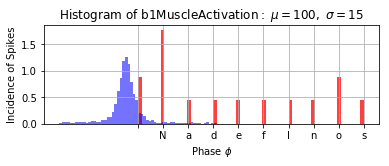

In [22]:
### Cumulative historgram or regular historgram

### for phase of B1 with and without crimson
###  degree of power muscle activation with and without crimson

#!/usr/bin/env python

plt.figure(13)
ax1 = plt.subplot(211)

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn

#split via crimson

#ax1.plot(times,crimson,'r')
#plt.fill_between(times[inds],crimson[inds])

crimson_labeled_spikes= zip(inst_phase[x_val_b], crimson[x_val_b], musc[x_val_b])


#plto inst phase


def cutoff_crimson(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList2 = filter(lambda x: x[1] > threshold, sortedData)
    finalList3 =filter(lambda x: x[1] < threshold+0.5, finalList2)
    finalList =filter(lambda x: x[1] < 45, finalList3)
    return finalList if len(finalList) > 2 else 'No values found'

Spikes_1_crimson = cutoff_crimson(2.2, crimson_labeled_spikes)
#Spikes_2_crimson = cutoff_crimson(0.2, crimson_labeled_spikes_2)

def cutoff_no_crimson(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList2 = filter(lambda x: x[1] < threshold, sortedData)
    finalList =filter(lambda x: x[0] < 45, finalList2)
    return finalList if len(finalList) > 2 else 'No values found'

Spikes_1_no_crimson = cutoff_no_crimson(0.20, crimson_labeled_spikes)
#Spikes_2_no_crimson = cutoff_no_crimson(0.2, crimson_labeled_spikes_2)



#print(zip_hutch)


x_val_crimson_1 = [x[0] for x in Spikes_1_crimson]
###x_val_crimson_2 = [x[2] for x in Spikes_2_crimson]
#x_val_crimson_1 = []

x_val_no_crim_1 = [x[0] for x in Spikes_1_no_crimson]
#x_val_no_crim_1 = []
###x_val_no_crim_2 = [x[2] for x in Spikes_2_no_crimson]
#x_val_no_crim_2 = []

#labeled_waveforms_type_a = [musc[pk-25:pk+40] for pk in x_val]

#labeled_waveforms_type_b = [musc[pk-25:pk+40] for pk in x_val_b]


hist_crimson_spikes = x_val_crimson_1 #+ x_val_crimson_2
hist_no_crimson_spikes = x_val_no_crim_1 #+ x_val_no_crim_2

matplotlib.pyplot.hist(hist_crimson_spikes, bins=60, normed=1, facecolor='red', alpha=0.75)
matplotlib.pyplot.hist(hist_no_crimson_spikes, bins=60, normed=1, facecolor='blue', alpha=0.55)


#mu, sigma = 100, 15
bins = 40
#x = mu + sigma*np.random.randn(10000)

# the histogram of the data
#n, bins, patches = plt.hist(musc_det[x_val_0], 50, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('Phase $\phi$')
plt.ylabel('Incidence of Spikes')
plt.title(r'$\mathrm{Histogram\ of\ b1 Muscle Activation:}\ \mu=100,\ \sigma=15$')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()


In [23]:
#### Maybe delete this


crimson = np.asarray(bl.segments[0].analogsignals[7])

indices = np.arange(len(crimson))

crimson_time= zip(indices, times, crimson)

def crimson_selection(threshold, data):
    sortedData = sorted(data, key=lambda x: x[2])
    finalList = filter(lambda x: x[2] > threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

crimson_selection_high = crimson_selection(8.0, crimson_time)



crimson_inds_1= zip(indices, crimson)

def crimson_selection_1(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] > threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

crimson_selection_high_1 = crimson_selection_1(5.0, crimson_inds_1)

####a
###Just take wave finder at those times!


def crimson_selection_none(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] < threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

crimson_selection_zero_stim = crimson_selection_none(0.1, crimson_inds_1)

print(crimson_selection_high_1[0])

# detrend hütchens signal
hutch_det = hutch - np.mean(hutch)

#hutch_seg = hutch[1260000:1263000]
#musc_seg = musc[1260000:1263000]

hutch_seg = hutch[crimson_selection_high_1[0][0]+500:crimson_selection_high_1[0][0]+5000]
musc_seg = musc[crimson_selection_high_1[0][0]+500:crimson_selection_high_1[0][0]+5000]

deltas = np.diff(np.array(-1*hutch_det[crimson_selection_high_1[0][0]+500:crimson_selection_high_1[0][0]+5000]>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]
  
#find the peak changes in the thresholded signal, and find the associated waveform   
hut_intervals = np.hstack((starts,stops))
huttimes = [np.argmax(hutch_seg[sta:stp])+sta for sta,stp in hut_intervals][2:-2]
hut_waveforms = [hutch_seg[pk-52:pk+44] for pk in huttimes]
musc_wave = [musc_seg[pk-52:pk+44] for pk in huttimes]

plt.figure(2)
plt.rc('font', size=12)
plt.rc('axes',linewidth=.5)
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['axes.linewidth'] = 2

fs_axon = 1.0/20000.0
t= np.linspace(0,len(hut_waveforms[0])/(1/fs_axon),len(hut_waveforms[0]))

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('w')

ax = fig.add_subplot(222)

for i in range(len(hut_waveforms)):
    ax.plot(t, hut_waveforms[i], 'r', alpha = 0.5)


ax.spines['left'].set_bounds(0, 2)
ax.set_ylim((-2, 4))
ax.set_xlim((-0.001, .005))
ax.set_yticks([])
ax.set_xticks([])
ax.tick_params(axis='both', which='major', pad=2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

    
ax2 = fig.add_subplot(224)
for i in range(len(musc_wave)):
    ax2.plot(t, musc_wave[i], 'r', alpha = 0.5)


ax2.spines['left'].set_bounds(-0.2, 0.2)
ax2.set_ylim((-2, 1.25))
ax2.set_xlim((-0.001, .005))
ax2.set_yticks([])
ax2.set_xticks([])
ax2.tick_params(axis='both', which='major', pad=2)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')


#hutch_seg = hutch[1010000:1013000]
#musc_seg = musc[1010000:1013000]

hutch_seg = hutch[crimson_selection_high_1[0][0]-4000:crimson_selection_high_1[0][0]-2000]
musc_seg = musc[crimson_selection_high_1[0][0]-4000:crimson_selection_high_1[0][0]-2000]



deltas = np.diff(np.array(-1*hutch_det[crimson_selection_high_1[0][0]-4000:crimson_selection_high_1[0][0]-2000]>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]
  
#find the peak changes in the thresholded signal, and find the associated waveform   
hut_intervals = np.hstack((starts,stops))
huttimes = [np.argmax(hutch_seg[sta:stp])+sta for sta,stp in hut_intervals][2:-2]
hut_waveforms = [hutch_seg[pk-52:pk+44] for pk in huttimes]
musc_wave = [musc_seg[pk-52:pk+44] for pk in huttimes]



ax = fig.add_subplot(222)

for i in range(len(hut_waveforms)):
    ax.plot(t, hut_waveforms[i], 'k', alpha = 0.5)

ax.set_ylabel('WBA (rel. units)')
ax.spines['left'].set_bounds(0, 2)
ax.set_ylim((-2, 4))
ax.set_xlim((-0.001, .005))
ax.set_yticks([0, 2])
ax.set_xticks([])
ax.tick_params(axis='both', which='major', pad=2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

    
ax2 = fig.add_subplot(224)
for i in range(len(musc_wave)):
    ax2.plot(t, musc_wave[i], 'k', alpha = 0.4) #0.5

ax2.set_ylabel('b1 (mV)')
ax2.spines['left'].set_bounds(-0.2, 0.2)
ax2.set_ylim((-2, 1.25))
ax2.set_xlim((-0.001, .005))
ax2.set_yticks([-.2, .2])
ax2.spines['bottom'].set_bounds(-0.001, 0)
ax2.set_xticks([-0.001, 0])
ax2.tick_params(axis='both', which='major', pad=2)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.spines['bottom'].set_visible(False)

ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')


plt.savefig('hutch_n_spike.pdf')
#gcf().savefig


N


TypeError: cannot concatenate 'str' and 'int' objects

In [1]:
#hutch_seg = hutch[1010000:1013000]
#musc_seg = musc[1010000:1013000]

hutch_seg = hutch[crimson_selection_high_1[0][0]-4000:crimson_selection_high_1[0][0]-2000]
musc_seg = musc[crimson_selection_high_1[0][0]-4000:crimson_selection_high_1[0][0]-2000]



deltas = np.diff(np.array(-1*hutch_det[crimson_selection_high_1[0][0]-4000:crimson_selection_high_1[0][0]-2000]>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]
  
#find the peak changes in the thresholded signal, and find the associated waveform   
hut_intervals = np.hstack((starts,stops))
huttimes = [np.argmax(hutch_seg[sta:stp])+sta for sta,stp in hut_intervals][2:-2]
hut_waveforms = [hutch_seg[pk-52:pk+44] for pk in huttimes]
musc_wave = [musc_seg[pk-52:pk+44] for pk in huttimes]



ax = fig.add_subplot(222)

for i in range(len(hut_waveforms)):
    ax.plot(t, hut_waveforms[i], 'k', alpha = 0.5)

ax.set_ylabel('WBA (rel. units)')
ax.spines['left'].set_bounds(0, 2)
ax.set_ylim((-2, 4))
ax.set_xlim((-0.001, .005))
ax.set_yticks([0, 2])
ax.set_xticks([])
ax.tick_params(axis='both', which='major', pad=2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

    
ax2 = fig.add_subplot(224)
for i in range(len(musc_wave)):
    ax2.plot(t, musc_wave[i], 'k', alpha = 0.4) #0.5

ax2.set_ylabel('b1 (mV)')
ax2.spines['left'].set_bounds(-0.2, 0.2)
ax2.set_ylim((-2, 1.25))
ax2.set_xlim((-0.001, .005))
ax2.set_yticks([-.2, .2])
ax2.spines['bottom'].set_bounds(-0.001, 0)
ax2.set_xticks([-0.001, 0])
ax2.tick_params(axis='both', which='major', pad=2)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.spines['bottom'].set_visible(False)

ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')




NameError: name 'hutch' is not defined